In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 简化版SMO算法

## 辅助函数

In [65]:
def loadData(filename):
    data = []; label = []
    fr = open(filename)
    for line in fr.readlines():
        linearr = line.strip().split('\t')
        data.append([float(linearr[0]), float(linearr[1])])
        label.append(float(linearr[2]))
    return np.array(data), np.array(label)

# 随机生成0~m之间的一个数
def selectJrand(i, m):
    j = i
    while j==i:
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj, H, L):#为过大或过小的alpha调整到边界上 0~C
    if aj > H: aj = H
    if L > aj: aj = L
    return aj

## load data

In [5]:
data, label = loadData('MLiAc6_testSet.txt')

(100, 2) (100,)
[3.542485 1.977398] -1


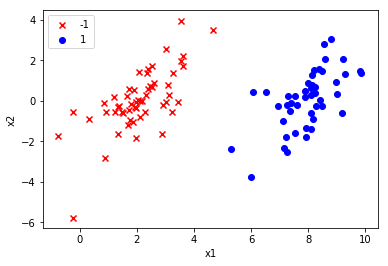

In [6]:
# label[:3]
print(data.shape,label.shape)
print(data[0],label[0])

# 学习如何分类画不同的颜色和标签
label1 = np.where(label.ravel() == -1)
plt.scatter(data[label1,0], data[label1,1], marker='x',color = 'r',label = '-1')

label2 = np.where(label.ravel() == 1)
plt.scatter(data[label2,0], data[label2,1], marker='o',color = 'b',label = '1')
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc = 'upper left')
plt.show()

## SMO

In [7]:
def SMO_simple(dataMatIn, classLabels, C, toler, maxIter):
            #  数据集       标签        常数C 容错率   最大迭代步数
    dataMatrix = np.mat(dataMatIn);
    labelMat = np.mat(classLabels).transpose()
    
    b = 0
    
    m,n = np.shape(dataMatrix)
    
    alphas = np.mat(np.zeros((m,1))) #alpha初始化为0
    
    iters = 0 #存储没有任何alpha改变的情况下遍历数据集的次数
    
    while (iters < maxIter):
        alphaPairsChanged = 0 #记录alpha是否已经进行优化
        
        # 对整个集合进行遍历
        for i in range(m):
            # fXi：预测的类别
            # Ei：误差
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            
            # 误差Ei很大，就对该实例对应的alpha进行优化;同时检查alpha值，保证在0~C之间，0、C为边界
            # 正负间隔都要测试
            if ((labelMat[i]*Ei <-toler)and(alphas[i]<C)) or ((labelMat[i]*Ei >toler)and(alphas[i]>0)):
                j = selectJrand(i,m) #新的alphat[j]
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                
                # 为旧alpha值分配新内存，便于稍后比较
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                
                # 计算L、H的值：用于将alpha[j]调整到0~C之间
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: #不做变动
                    #print "L==H"
                    continue #本次循环结束，进入下一个for循环
                
                # eta：alpha[j]的最优修改量
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: 
                    #print "eta>=0"
                    continue
                # 计算新的alpha[j]
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                #微调
                alphas[j] = clipAlpha(alphas[j],H,L)
                
                # 检查alpha[j]是否有轻微改变
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    #print "j not moving enough"
                    continue #是的话就退出当前循环
                
                # 对alpha[i]进行与j相同量反方向的调整
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                # 给这两个alpha设置一个常数项
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                
                # 如果for循环执行到这里都没有执行一次continue语句，那么就已经成功改变了一对alpha的值
                # 同时，增加alpha改变的次数统计
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iters,i,alphaPairsChanged))
                
        # 检查alpha是否做了更新
        if (alphaPairsChanged == 0): iters += 1
        else: iters = 0 #有更新将iters设置为0后继续, 只要有更新，就从头再来一遍
        print("iteration number: %d" % iters)
        
        # 只有在所有数据集上遍历maxIter次，且不再发生任何alpha修改后，程序才会停止并退出while循环
    return b,alphas

In [10]:
b, alphas = SMO_simple(data, label, C=0.6, toler=0.001, maxIter=40)

iter: 0 i:1, pairs changed 1
iter: 0 i:4, pairs changed 2
iter: 0 i:29, pairs changed 3
iter: 0 i:46, pairs changed 4
iteration number: 0
iter: 0 i:52, pairs changed 1
iter: 0 i:55, pairs changed 2
iteration number: 0
iter: 0 i:45, pairs changed 1
iter: 0 i:46, pairs changed 2
iter: 0 i:68, pairs changed 3
iteration number: 0
iter: 0 i:29, pairs changed 1
iter: 0 i:36, pairs changed 2
iter: 0 i:46, pairs changed 3
iter: 0 i:54, pairs changed 4
iter: 0 i:56, pairs changed 5
iteration number: 0
iter: 0 i:23, pairs changed 1
iter: 0 i:29, pairs changed 2
iter: 0 i:52, pairs changed 3
iteration number: 0
iter: 0 i:24, pairs changed 1
iter: 0 i:52, pairs changed 2
iteration number: 0
iter: 0 i:69, pairs changed 1
iteration number: 0
iter: 0 i:52, pairs changed 1
iteration number: 0
iter: 0 i:15, pairs changed 1
iter: 0 i:69, pairs changed 2
iteration number: 0
iter: 0 i:11, pairs changed 1
iter: 0 i:24, pairs changed 2
iter: 0 i:54, pairs changed 3
iteration number: 0
iter: 0 i:11, pairs ch

iter: 0 i:55, pairs changed 1
iteration number: 0
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iteration number: 9
iteration number: 10
iteration number: 11
iteration number: 12
iter: 12 i:29, pairs changed 1
iteration number: 0
iteration number: 1
iteration number: 2
iteration number: 3
iter: 3 i:55, pairs changed 1
iteration number: 0
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iteration number: 9
iteration number: 10
iteration number: 11
iteration number: 12
iteration number: 13
iteration number: 14
iteration number: 15
iteration number: 16
iter: 16 i:29, pairs changed 1
iteration number: 0
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iter: 8 

In [11]:
b

matrix([[-3.82367914]])

In [14]:
alphas[alphas>0] #alphas 

matrix([[0.10695512, 0.2566814 , 0.01861849, 0.34501803]])

In [19]:
# 支持向量的个数
np.shape(alphas[alphas>0])[1] #(1, 4)

4

In [20]:
# 支持向量 及其 类别标签
for i in range(100):
    if alphas[i]>0.0:
        print(data[i], label[i])

[4.658191 3.507396] -1
[ 3.457096 -0.082216] -1
[ 5.286862 -2.358286] 1
[6.080573 0.418886] 1


## 画图 圈出支持向量

In [24]:
# 基于alpha的值得到超平面，w的计算
def calcWs(alphas,data,Labels):
    X = np.mat(data)
    label = np.mat(Labels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*label[i],X[i,:].T) #绝大多数的alpha=0，非零alpha对应的就是支持向量
    return w

w = calcWs(alphas, data, label.ravel())
print(w.shape)
print(w)

(2, 1)
[[ 0.81075109]
 [-0.25341516]]


In [ ]:
def plotSV(x, y, alphas, b, w):
    plt.figure(figsize=(6.5,6.5))
    
    label1 = np.where(y.ravel() == -1)
    plt.scatter(x[label1,0],x[label1,1], marker='x',color = 'red',label = '-1')
    
    label2 = np.where(y.ravel() == 1)
    plt.scatter(x[label2,0],x[label2,1], marker='s',color = 'black',label = '1')

    #画出支持向量
    supportIndex = np.nonzero(alphas>0)[0]
    plt.plot(x[supportIndex,0], x[supportIndex,1], 'bo', markersize=15, fillstyle='none')

    #使用已知的参数画出超平面
    b0 = b[0,0] 
    w0=w[0,0]
    w1=w[1,0]
    
    x0 = np.arange(-2.0, 12.0, 0.1)
    y0 = (-w0*x0 - b0)/w1
    
    plt.plot(x0,y0)
    plt.axis([-2,12, -8,6])

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc = 'upper left')
    plt.show()

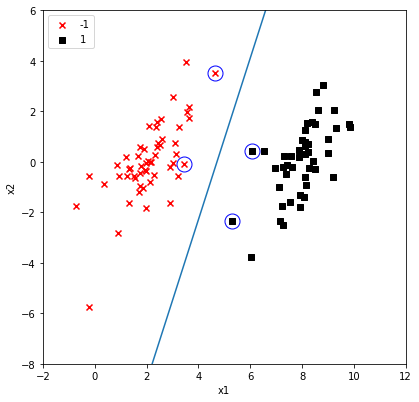

In [26]:
plotSV(data, label, alphas, b, w)

# 完整的Plat SMO

## 辅助函数

In [ ]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  
        # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        # 误差缓存
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag
        
        self.K = np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)


# 计算E值并返回
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

# 内循环的alpha值 选择第二个alpha
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

# 计算误差并存储缓存中
def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]
        
# 优化例程
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print("L==H"); return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: print("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

## 核转换函数

In [70]:
# kernel
def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

## SMO

In [53]:
def SMO(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

## use

In [ ]:
data, label = loadData('MLiAc6_testSet.txt')

In [54]:
b, alphas = SMO(data, label, 0.6, 0.001,40)

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
j not moving enough
fullSet, iter: 0 i:7, pairs changed 2
L==H
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
L==H
fullSet, iter: 0 i:10, pairs changed 2
L==H
fullSet, iter: 0 i:11, pairs changed 2
L==H
fullSet, iter: 0 i:12, pairs changed 2
fullSet, iter: 0 i:13, pairs changed 2
L==H
fullSet, iter: 0 i:14, pairs changed 2
fullSet, iter: 0 i:15, pairs changed 2
fullSet, iter: 0 i:16, pairs changed 2
L==H
fullSet, iter: 0 i:17, pairs changed 2
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
j not moving enough
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, 

In [60]:
# 支持向量 及其 类别标签
j = 0
for i in range(100):
    if alphas[i]>0.0:
        j+=1
        print(j, data[i], label[i])

1 [3.542485 1.977398] -1
2 [ 2.114999 -0.004466] -1
3 [8.127113 1.274372] 1
4 [4.658191 3.507396] -1
5 [8.197181 1.545132] 1
6 [ 7.40786  -0.121961] 1
7 [ 6.960661 -0.245353] 1
8 [6.080573 0.418886] 1
9 [3.107511 0.758367] -1


In [55]:
w = calcWs(alphas, data, label.ravel())

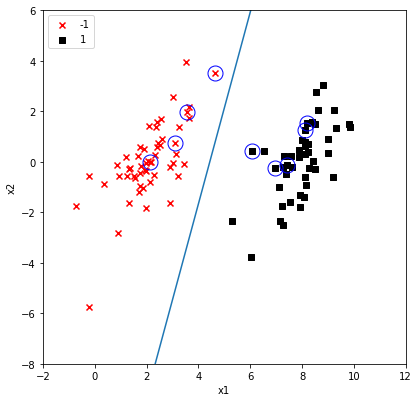

In [56]:
plotSV(data, label, alphas, b, w)

# 在测试中使用核函数

In [82]:
def testRbf(k1=1.3):
    dataArr,labelArr = loadData('MLiAc6_testSetRBF.txt')
    b,alphas = SMO(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat= np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    
    svInd= np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print ("there are %d Support Vectors" % np.shape(sVs)[0])
    
    m,n = np.shape(datMat)
    errorCount = 0
    
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!= np.sign(labelArr[i]): errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    
    dataArr,labelArr = loadData('MLiAc6_testSetRBF2.txt')
    errorCount = 0
    datMat= np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!= np.sign(labelArr[i]): 
            errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m))

In [83]:
testRbf()

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 1
fullSet, iter: 0 i:3, pairs changed 2
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 3
fullSet, iter: 0 i:6, pairs changed 4
fullSet, iter: 0 i:7, pairs changed 4
j not moving enough
fullSet, iter: 0 i:8, pairs changed 4
fullSet, iter: 0 i:9, pairs changed 4
fullSet, iter: 0 i:10, pairs changed 4
j not moving enough
fullSet, iter: 0 i:11, pairs changed 4
fullSet, iter: 0 i:12, pairs changed 4
fullSet, iter: 0 i:13, pairs changed 4
fullSet, iter: 0 i:14, pairs changed 4
fullSet, iter: 0 i:15, pairs changed 5
fullSet, iter: 0 i:16, pairs changed 5
j not moving enough
fullSet, iter: 0 i:17, pairs changed 5
fullSet, iter: 0 i:18, pairs changed 5
fullSet, iter: 0 i:19, pairs changed 5
fullSet, iter: 0 i:20, pairs changed 5
fullSet, iter: 0 i:21, pairs changed 6
fullSet, iter: 0 i:22, pairs changed 6
fullSet, iter: 0 i:23, pairs changed 7
fullSet, iter:

the training error rate is: 0.070000
the test error rate is: 0.080000


# 手写识别问题

In [ ]:
    
def img2vector(filename):
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

In [ ]:
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels    

In [ ]:
def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print "there are %d Support Vectors" % shape(sVs)[0]
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print "the training error rate is: %f" % (float(errorCount)/m)
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print "the test error rate is: %f" % (float(errorCount)/m) 